<a href="https://colab.research.google.com/github/heysourin/Attention-is-all-you-need-Reimplementation/blob/main/Transformer_Attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip -q install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import math

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

from typing import Any

from tqdm import tqdm

import warnings

In [ ]:
class InputEmbedding(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, seq_len: int, dropout: float):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (- math.log(10000.0)/d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0) #eg (5, 8) to (1, 5, 8)

    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # not requires_grad_(False) --> not training ---> a/c to the paper

    return self.dropout(x)

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float)->None:
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, 'd_model must be divisible by h'

    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    self.w_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)


  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]

    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
      attention_scores.masked_fill_(mask == 0, -1e9)

    attention_scores = attention_scores.softmax(dim=-1)
    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return (attention_scores@value), attention_scores

  def forward(self, q, k, v, mask):
    query = self.w_q(q) # (1, 11, 512)
    key = self.w_k(k) # (1, 11, 512)
    value = self.w_v(v) # (1, 11, 512)

        #(batch_size, seq_len, h, d_k) --> (batch_size, h, seq_len, d_k)    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2) # (1, 11, 512) --> (1, 11, 8, 64)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

    x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k) #(1, 11, 8, 64) --> (1, 11, 512)

    return self.w_o(x)

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, eps:float=10**-6)-> None:
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True, unbiased=False)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model:int, d_ff:int, dropout:float)->None:
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

# **Residual Connections:**
- Red lines by pen are residual connections:

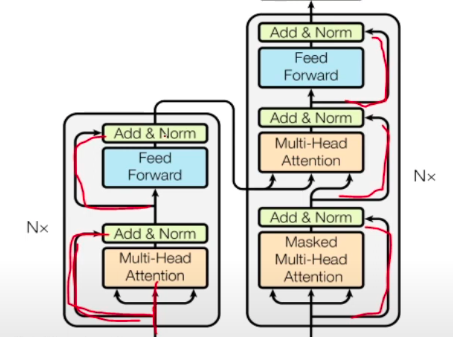

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout:float)->None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization() #layernormalization class from above

  #x=main line, sublayer=MHA (in case of first residual connectoin).
  # sublayer is FFN in case of the second one
  def forward(self, x, sublayer):
    # return x + self.dropout(self.norm(sublayer(x))) ## a/c to the paper
    return x + self.dropout(sublayer(self.norm(x))) ## a/c to harvard university experts --> nomalize before sending to the sublayer.

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, self_attention_block:MultiHeadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout:float)-> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block

    # requires loop to run 2x for two residual connections
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

## When to Use nn.ModuleList?
  #1 When you need a variable number of layers in your model.
  #2 When you want to group layers while still allowing them to be part of the PyTorch computation graph.

  def forward(self, x, src_mask):
    y = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
    z = self.residual_connections[1](y, self.feed_forward_block)
    return z

    #how is it calling attention() funciton directly without even naming it!?

In [ ]:
"""
layers: it is gonna have 6 encoders
""""
class Encoder(nn.Module):
  def __init__(self, layers:nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block:MultiHeadAttentionBlock,feed_forward_block:FeedForwardBlock, dropout:float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])# requires loop to run 3x for two residual connections

  #? what are the things a decoder needs: x, encoder_output, source_mask, target_mask
  def forward(self, x, encoder_output, src_mask, tgt_mask):
    d = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    s = self.residual_connections[1](x, lambda x:self.cross_attention_block(d, encoder_output, encoder_output, src_mask))
    t = self.residual_connections[2](x, feed_forward_block(s))

    return t

In [ ]:
"""
layers: it is gonna have 6 decoders
""""
class Decoder(nn.Module):
  def __init__(self, layers:nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

#**Linear and softmax layer**: Above decoder

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model:int, vocab_size:int) -> None:
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return torch.log_softmax(self.proj(x), dim=-1)

## **Writing complete Transformer**:

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder:Encoder, decoder:Decoder, src_embed:InputEmbedding, tgt_embed:InputEmbedding, src_pos:PositionalEncoding, tgt_pos:PositionalEncoding, projection_layer:ProjectionLayer) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_post(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output, src_mask, tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

  def project(self, x):
    return self.projection_layer(x)

In [ ]:
"""
@params:
N = Number of encoders and decoders in the architecture.
d_ff = Number of hidden neurons in the feed forward netowrk.
"""

def build_transformer(src_vocab_size:int, tgt_vocab_size:int, src_seq_len:int, tgt_seq_len:int, d_model:int=512, N:int=6, h:int=8, dropout:float=0.1, d_ff:int=2048) -> Transformer:
  src_embed = InputEmbedding(d_model, src_vocab_size)
  tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)

    encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)

    encoder_blocks.append(encoder_block)

  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)

    decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)

    decoder_blocks.append(decoder_block)

  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer